# Convolutional Autoencoder for Anomaly Detection
## Learning Objectives
1. Learn how to build a Deep Convolutional Autoencoder
2. Learn how to use a trained autoencoder for anomaly detection

In this lab, you will learn how to build an autoencoder model. Autoencoder is a popular unsupervised model which consists of an encoder and a decoder.<br>
An autoencoder is a special type of neural network trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error.

Autoencoders can be used in many ways. In this lab, we will use an autoencoder for anomaly detection, leveraging that an autoencoder will have a harder time reconstructing an anomalous input compared to an input taken from the data distribution it has been trained on."

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.


In [1]:
# Import libraries and modules
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.set_printoptions(threshold=np.inf)

### Load MNIST Data

We are going to use the MNIST dataset, which consists of black and white images of handwritten digits. Each image has 28 x 28 pixels and a single channel indicating the level of gray between black and white, yielding a tensor representation with shape(28, 28, 1). Keras comes preloaded with this dataset, which we load in the next cell:"

In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

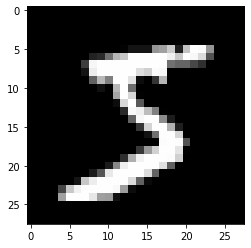

In [3]:
plt.imshow(mnist_digits[0], cmap="Greys_r")

## Build Autoencoder model
Let's start building an autoencoder model. 

Autoencoder is a self-supervised model, which uses the same data for input and label. 

![image](https://user-images.githubusercontent.com/6895245/164359926-f72472ca-f2de-4098-bf2b-3e649749f721.png)
It tries to reduce the dimensionality of inputs to a fixed-sized latent space (encoder) and 'reconstruct' the input from the embedding (decoder). So we can regard the encoder part as a dimensionality reduction model like PCA. But whereas PCA learns a linear transformation that projects input into lower-dimensional space, autoencoders learn non-linear transformation using Neural Networks.

### Encoder
Let's build the encoder part at first. Encoder goes from the inputs to the latent space.
![image](https://user-images.githubusercontent.com/6895245/164373070-f7860451-1720-4e4b-aa91-460c4aa98020.png)


In [4]:
def build_encoder(
    input_shape,
    latent_dim,
    filters_1=32,
    filters_2=64,
    kernel_size_1=3,
    kernel_size_2=3,
    strides_1=2,
    strides_2=2,
):

    encoder = tf.keras.Sequential(
        [
            keras.Input(shape=input_shape, name="image_input"),
            layers.Conv2D(
                filters=filters_1,
                kernel_size=kernel_size_1,
                activation="relu",
                strides=strides_1,
                padding="same",
                name="encoder_convolution_1",
            ),
            layers.Conv2D(
                filters=filters_2,
                kernel_size=kernel_size_2,
                activation="relu",
                strides=strides_2,
                padding="same",
                name="encoder_convolution_2",
            ),
            layers.Flatten(name="encoder_flatten"),
            layers.Dense(latent_dim, name="encoder_output"),
        ],
        name="encoder",
    )
    return encoder

In [5]:
LATENT_DIM = 2  # for easy visualization
INPUT_SHAPE = (28, 28, 1)  # Size of input data

encoder = build_encoder(INPUT_SHAPE, LATENT_DIM)
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_convolution_1 (Conv2 (None, 14, 14, 32)        320       
_________________________________________________________________
encoder_convolution_2 (Conv2 (None, 7, 7, 64)          18496     
_________________________________________________________________
encoder_flatten (Flatten)    (None, 3136)              0         
_________________________________________________________________
encoder_output (Dense)       (None, 2)                 6274      
Total params: 25,090
Trainable params: 25,090
Non-trainable params: 0
_________________________________________________________________


2022-04-25 11:54:44.118632: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 11:54:44.132180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 11:54:44.132784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-25 11:54:44.134294: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### Decoder
The decoder goes from the latent space back to the reconstructed image.
In order to reconstruct the original shape (28,28,1), we use [`Conv3DTranspose` layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) (a.k.a Deconvolution).

![image](https://user-images.githubusercontent.com/6895245/164372979-29797db4-d108-4955-8056-ec668465c3f4.png)


In [8]:
def build_decoder(latent_dim, encoder):
    decoder = tf.keras.Sequential(
        [
            keras.Input(shape=latent_dim, name="decoder_input"),
            layers.Dense(
                encoder.layers[-1].input.shape[1],  # 3136
                activation="relu",
                name="decoder_dense",
            ),
            layers.Reshape(
                encoder.layers[-2].input.shape[1:],  # ([7, 7, 64])
                name="decoder_reshape",
            ),
            layers.Conv2DTranspose(
                filters=encoder.layers[-3].input.shape[-1],  # 32
                kernel_size=encoder.layers[-3].kernel_size,  # 3
                activation="relu",
                strides=encoder.layers[-3].strides,  # 2
                padding="same",
                name="decoder_deconvolution_1",
            ),
            layers.Conv2DTranspose(
                filters=encoder.layers[-4].input.shape[-1],  # 1
                kernel_size=encoder.layers[-4].kernel_size,  # 3
                activation="sigmoid",
                strides=encoder.layers[-4].strides,  # 2
                padding="same",
                name="decoder_deconvolution_2",
            ),
        ],
        name="decoder",
    )
    return decoder

In [9]:
decoder = build_decoder(LATENT_DIM, encoder)
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_dense (Dense)        (None, 3136)              9408      
_________________________________________________________________
decoder_reshape (Reshape)    (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_deconvolution_1 (Con (None, 14, 14, 32)        18464     
_________________________________________________________________
decoder_deconvolution_2 (Con (None, 28, 28, 1)         289       
Total params: 28,161
Trainable params: 28,161
Non-trainable params: 0
_________________________________________________________________


### Construct entire autoencoder

The autoencoder consists of the encoder and the decoder blocks. Let's simply stack these two and build the entire autoencoder model.

In [10]:
def build_autoencoder(input_shape, latent_dim):
    encoder = build_encoder(input_shape, latent_dim)
    decoder = build_decoder(latent_dim, encoder)
    autoencoder = tf.keras.Sequential([encoder, decoder])
    autoencoder.build(input_shape=(None, *input_shape))
    return encoder, decoder, autoencoder

In [11]:
encoder, decoder, autoencoder = build_autoencoder(INPUT_SHAPE, LATENT_DIM)

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 2)                 25090     
_________________________________________________________________
decoder (Sequential)         (None, 28, 28, 1)         28161     
Total params: 53,251
Trainable params: 53,251
Non-trainable params: 0
_________________________________________________________________


### Reconstruction Loss

The optimization goal of the autoencoder is to minimize the reconstruction error between input and output. So let's chose MSE as the loss function.

In [12]:
autoencoder.compile(optimizer=keras.optimizers.Adam(), loss="mse")

## Train autoencoder
Let's run the training by calling `.fit()`.
Here, please notice that both feature and label have the same shape, i.e., (28, 28, 1).

In [13]:
history = autoencoder.fit(mnist_digits, mnist_digits, epochs=30, batch_size=128)

2022-04-25 11:55:04.681417: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-04-25 11:55:05.680571: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8200


547/547 [==============================] - 5s 4ms/step - loss: 0.0704
Epoch 2/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0532
Epoch 3/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0510
Epoch 4/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0490
Epoch 5/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0474
Epoch 6/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0464
Epoch 7/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0457
Epoch 8/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0452
Epoch 9/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0447
Epoch 10/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0443
Epoch 11/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0440
Epoch 12/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0438
Epoch 13/30
547/547 [===============

It looks the reconstruction loss is decreasing gradually.


## Visualize the latent space

We trained an autoencoder model with `LATENT_DIM=2`. Let's visualize the 2 dimensional latent space (output of encoder), and see how it found the pattern from input data.

The function bellow will plot the input images in the latent space by passing them to the encoder. It will also add the indication of the actual image labels (which were not used during the autoencoder training). We observe that the autoencoder was able to group images with the same label into relatively well defined cluster of points in the latent space. In a way, the autoencoder has "guessed" the image labels from the raw images without having the knowledge of the labels during training!


In [14]:
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    for label in range(10):  # mnist, 10 digits
        cx = np.mean(z_mean[labels == label, 0])
        cy = np.mean(z_mean[labels == label, 1])
        plt.text(
            cx, cy, str(label), color="white", fontsize=25, fontweight="bold"
        )
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

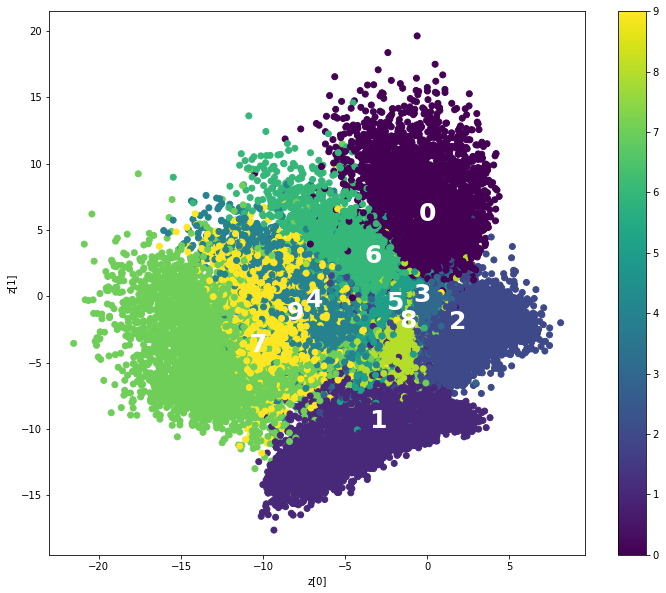

In [16]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, x_train, y_train)

We can see clusters of digits! That means our encoder part found some patern and embedded information in this 2 dimensional latent space.

## Visualize decoder
Now let's take a look at the decoder part as well.
The helper function below creates grid pairs of two dimensional latent space  (`grid_x` and `grid_y`) in a specified range, then passes them to the decoder and plots the decoder model's output.<br>
It helps us understand how the decoder generate output images from latent spaces.

You can change the `ranges` argument in `[x_min, x_max, y_min, y_max]` format based on the actual range of the clusters in a latent space of the encoder output that is shown above.

In [17]:
def plot_latent_space(decoder, n=30, ranges=[-1, 1, -1, 1], figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(ranges[0], ranges[1], n)
    grid_y = np.linspace(ranges[2], ranges[3], n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

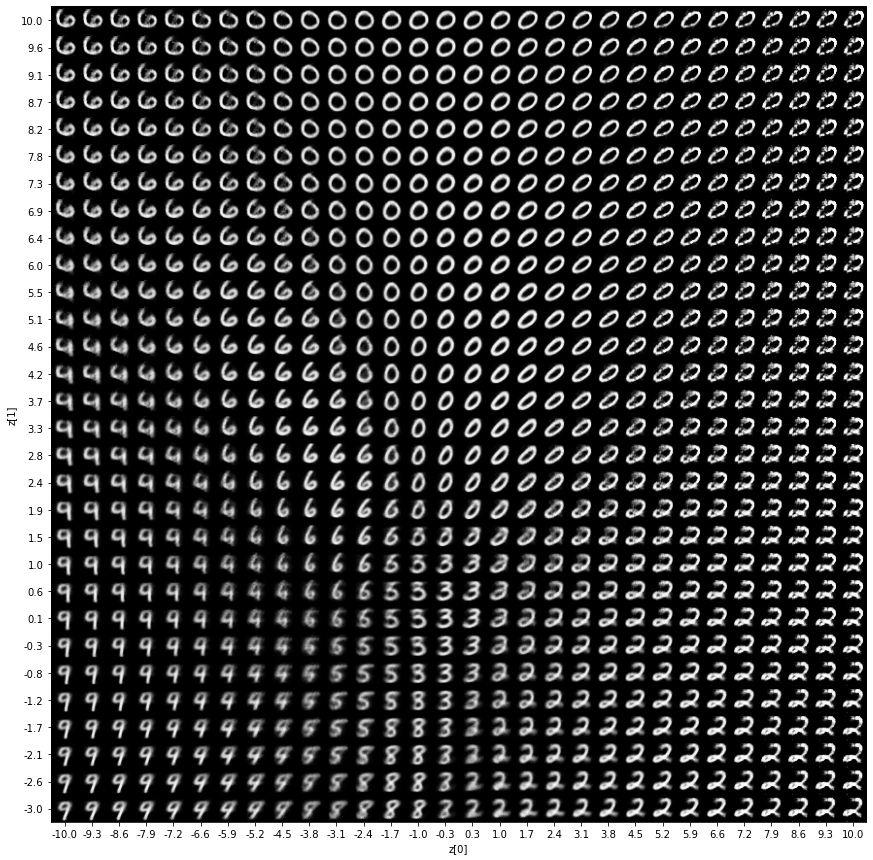

In [18]:
plot_latent_space(decoder, n=30, ranges=[-10, 10, -3, 10], figsize=15)

It looks good! Our autoencoder model successfully reconstructs the images from two-dimensional latent space.

Next, let's take a look at how we can use autoencoder to solve the Anomaly Detection problem.

## Anomaly Detection
Now that we demonstrated how autoencoder works, let's utilize this model for anomaly detection.

But why does this work for anomaly detection?

Autoencoder learns the pattern of data by compressing the information and reconstructing it. So if it is successfully trained with 'normal' data, it should be able to rebuild a similar image to 'normal' inputs as we've seen. But if the input was 'anomaly,' it won't reconstruct a similar image since the pattern of anomaly data is very different from normal data.

So in the anomaly case, the error between input and output should be larger than the normal case. We can utilize this characteristic of autoencoder for anomaly detection problems.

### Build AutoEncoder for Anomaly Detection

Before actually using an autoencoder for anomaly detection, let's create a more performant model by specifying a larger latent dimension.

A larger latent dimension means the model can embed richer information in a larger space.

In [19]:
encoder, decoder, autoencoder = build_autoencoder(INPUT_SHAPE, latent_dim=32)

In [20]:
autoencoder.compile(optimizer=keras.optimizers.Adam(), loss="mse")
history = autoencoder.fit(mnist_digits, mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 3s 4ms/step - loss: 0.0471
Epoch 2/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0077
Epoch 3/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0058
Epoch 4/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0051
Epoch 5/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0047
Epoch 6/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0045
Epoch 7/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0043
Epoch 8/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0041
Epoch 9/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0040
Epoch 10/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0039
Epoch 11/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0038
Epoch 12/30
547/547 [==============================] - 2s 4ms/step - loss: 0.0038
Epoch 13/30
547/547 [====

### Detect Anomalies

In the next cell, we will detect anomalies by computing the reconstruction error of a given input, and checking if it crosses a threshold, that we establish by computing the mean and the standard deviation of the reconstruction error on the dataset according to the following formula:

`threshold = mean(reconstruction_error) + std(reconstruction_error) + sigma`

where sigma is an hyper-parameter that we need to set. 

In [21]:
num_sample = 2000  # Number of samples to caliculate threshold

reconstructions = autoencoder.predict(x_train[:num_sample])
train_loss = tf.reduce_mean(
    tf.keras.losses.mae(reconstructions, x_train[:num_sample]), axis=(1, 2)
)

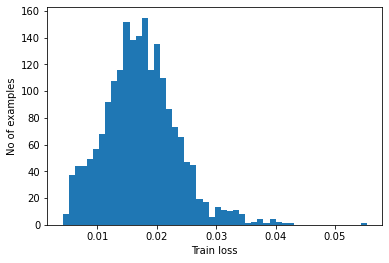

In [22]:
# Visualize histgram of loss value
plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Let's choose a threshold value that is two standard deviations above the mean.

In [23]:
# Define Anomaly Threshold
sigma = 2

threshold = np.mean(train_loss) + np.std(train_loss) * sigma
print("Threshold: ", threshold)

Threshold:  0.02953330148011446


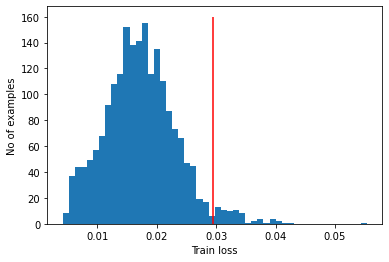

In [24]:
# Visualize histgram of loss value and anomaly threshold
fig = plt.figure()
plt.hist(train_loss[None, :], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.vlines(threshold, 0, 160, color="red")
plt.show()

### Prediction
At prediction time we

1. reconstruct the input using the autoencoder
1. compute the reconstruction error for that input
1. classify the input as an anomaly if the reconstruction error is above the threshold we have fixed

In [25]:
# Detection function
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.reduce_mean(
        tf.keras.losses.mae(reconstructions, data), axis=(1, 2)
    )
    return tf.math.greater(loss, threshold), loss[0], reconstructions

This helper function below visualizes input, reconstructed output, and the result of anomaly detection with a comparison of the actual loss value and the threshold.

In [26]:
# Ploting Utility Function
def plot_reconstruction(model, data, threshold):
    is_anomaly, loss, reconstruction = predict(
        model, tf.expand_dims(data, 0), threshold
    )

    f, axarr = plt.subplots(1, 2)
    lossMSG = f"loss:{loss:.4f}"
    thMSG = f"threshold:{threshold:.4f}"
    text_anomaly = (
        f"Anomaly ({lossMSG} > {thMSG})"
        if is_anomaly
        else f"Normal ({lossMSG} <= {thMSG})"
    )
    title = f.suptitle(text_anomaly)
    c = "r" if is_anomaly else "g"
    plt.setp(title, color=c)

    axarr[0].imshow(data, cmap="Greys_r")
    axarr[0].set_title("Original Image")
    axarr[1].imshow(reconstruction[0], cmap="Greys_r")
    axarr[1].set_title("Reconstructed Image")
    f.show()

### Normal dataset
Let's pass some normal data from the dataset and see how our autoencoder model responds.

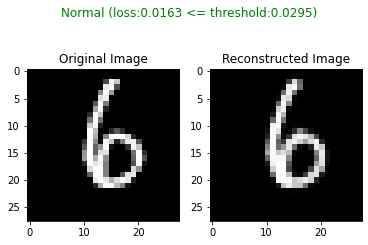

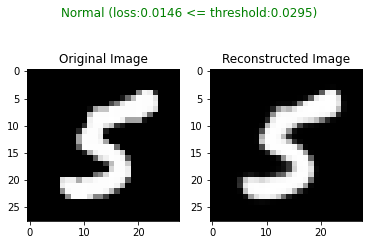

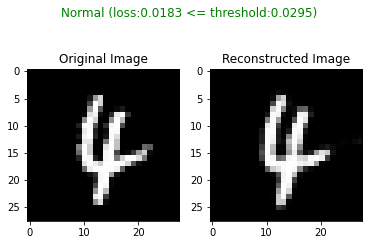

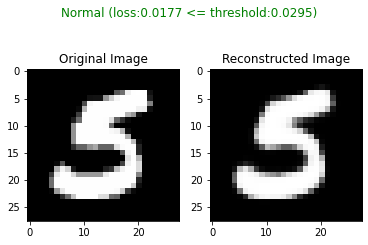

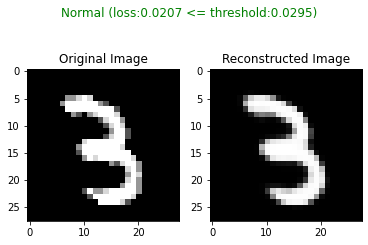

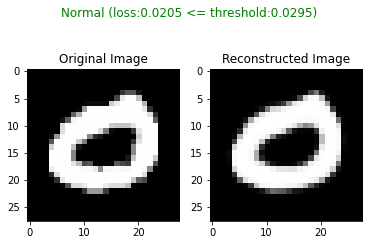

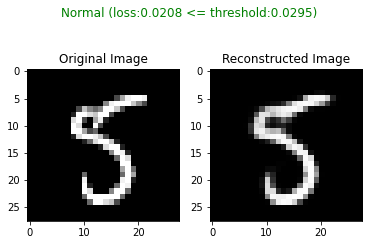

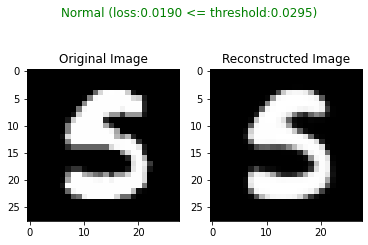

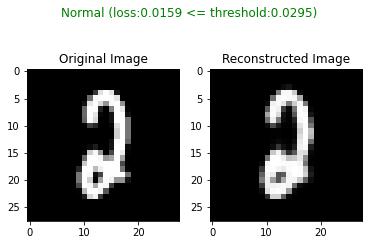

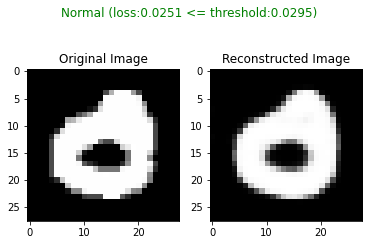

In [27]:
for d in x_train[num_sample - 10 : num_sample]:
    plot_reconstruction(autoencoder, d, threshold)

Looks Like our autoencoder is reconstructing images very well, and the loss value is less than the threshold in most cases.<br>
This is what we expected!

### Try Anomaly Data
Then what happens when it gets 'unusual' data? Let's create some perturbations below and see what happens. We try:
- 90-degree rotated images
- negatively inversed images
- images with white noise

#### 90-degree rotated images

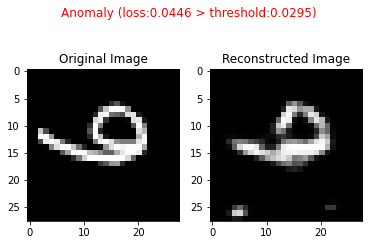

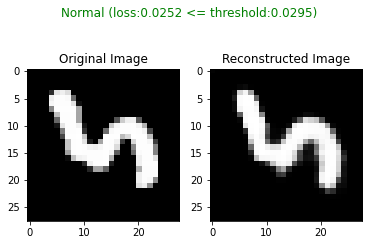

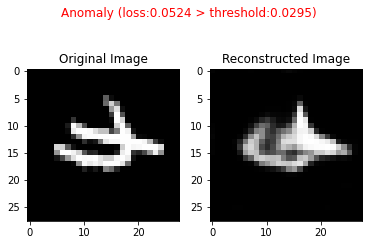

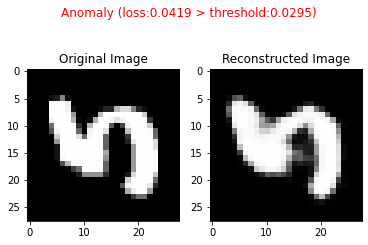

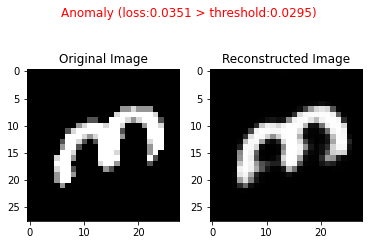

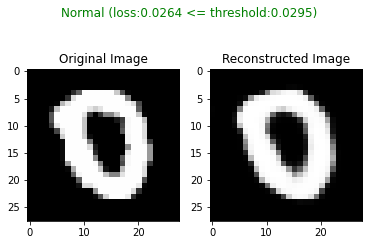

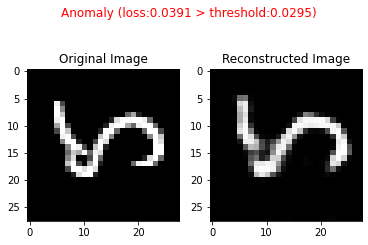

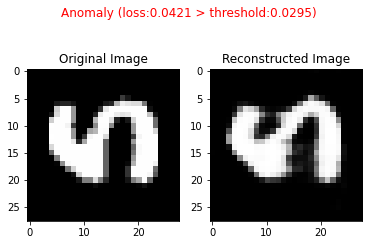

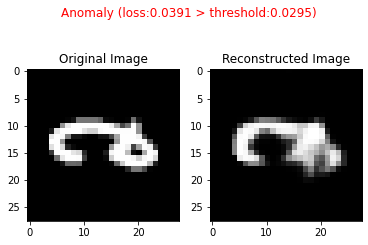

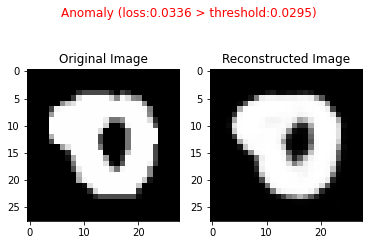

In [28]:
for d in x_train[num_sample - 10 : num_sample]:
    plot_reconstruction(autoencoder, np.rot90(d), threshold)

It looks a lot of rotated images are detected as anomalies since rotated images are not contained in training and threshold calculation.

But since the `0` value is invariable to angles, rotated `0` can be detected as normal.

Next, let's look at what happens if we create negatives from the original images and provide them to our model.

#### negatively inversed images

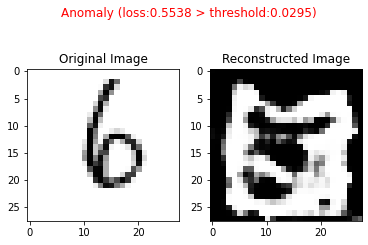

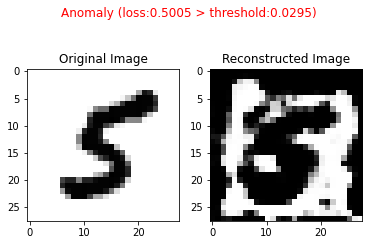

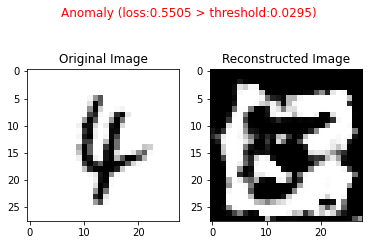

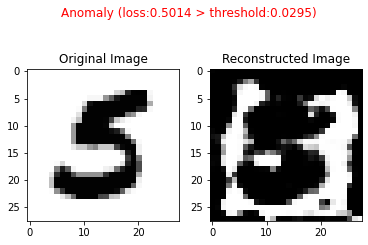

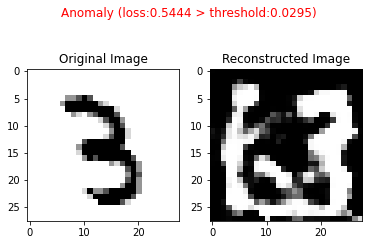

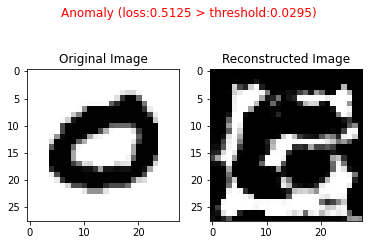

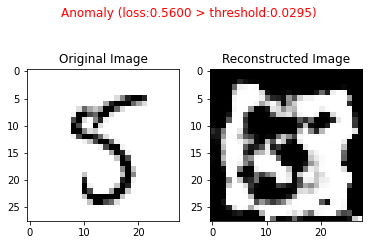

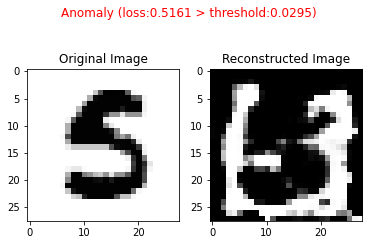

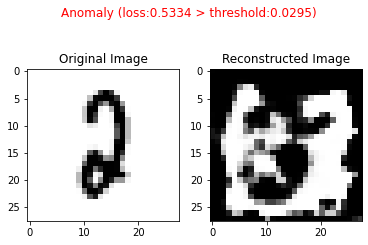

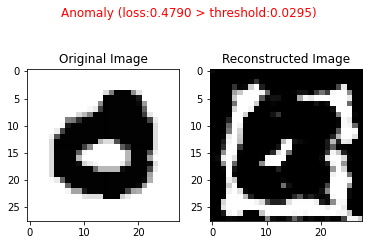

In [29]:
for d in x_train[num_sample - 10 : num_sample]:
    plot_reconstruction(autoencoder, 1 - d, threshold)

They are detected as anomalies with considerable loss value! And we can see our model cannot construct the original image at all.

Then how about the noisy data?

#### images with white noise

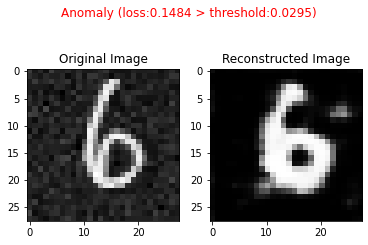

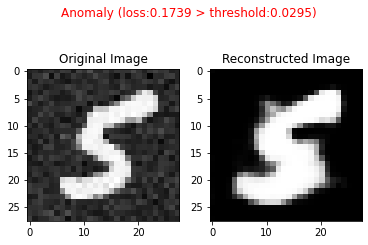

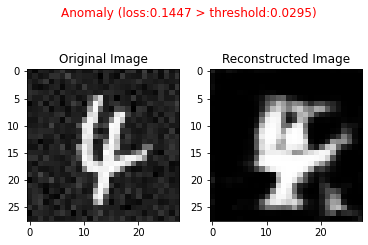

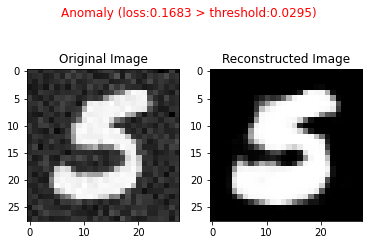

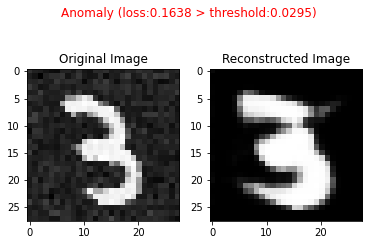

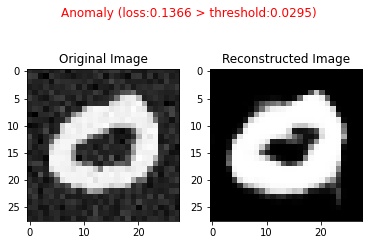

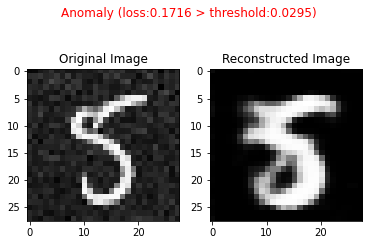

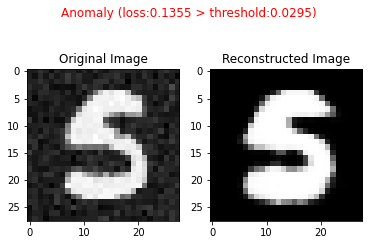

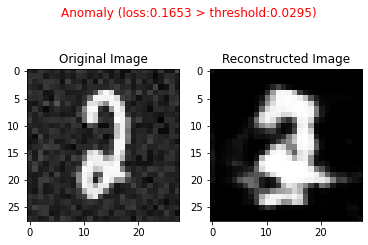

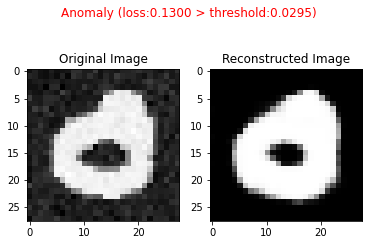

In [30]:
def add_noise_and_scale(d):
    noise = np.random.normal(0, 0.05, size=(28, 28, 1))
    _d = d + noise
    return _d - np.min(_d) / (np.max(_d) - np.min(_d))


for d in x_train[num_sample - 10 : num_sample]:
    plot_reconstruction(autoencoder, add_noise_and_scale(d), threshold)

They are also detected as anomalies!

Interestingly, since our autoencoder was trained with clean images, it tries to 'denoise' and generates clean images as outputs. As a result, the error between the inputs and clean outputs becomes large, and they are detected as anomalies.

Is that mean we can also utilize autoencoders for denoising purposes? Yes, we can do it with [denoising autoencoders](https://www.cs.toronto.edu/~larocheh/publications/icml-2008-denoising-autoencoders.pdf).<br>
But then don't forget to use clean images for training data to make autoencoders capture the pattern of clean data.



## Summary
We learned how to build an autoencoder model by stacking an encoder and a decoder in this lab.<br>
Also, we learned how to utilize an autoencoder for anomaly detection purposes.

# License

Copyright 2022 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.